#    Imports

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# Importing and merging data 

## Reading .csv with player id and market value and choosing end of the season prices

In [97]:

df = pd.read_csv("player_valuations.csv")

df['date'] = pd.to_datetime(df['date'])

df = df[(df['date'].between('2019-04-01', '2019-07-01'))]


df = df.drop_duplicates(subset='player_id', keep='first')
print(len(df))


df.to_csv("parsed_eng_players.csv", index=False)

print(df.head(10))


14551
        player_id       date  market_value_in_eur  current_club_id  \
266329      34773 2019-04-01               200000            23611   
266330      59423 2019-04-01               100000             6414   
266331     172546 2019-04-01                50000            41201   
266332     263941 2019-04-01               200000             2439   
266333     279052 2019-04-01               250000              964   
266334     281881 2019-04-01               100000             3729   
266335     330059 2019-04-01               150000              932   
266336     340866 2019-04-01               150000            10690   
266337     345408 2019-04-01               200000            28095   
266338     351168 2019-04-01               200000            14589   

       player_club_domestic_competition_id  
266329                                UKR1  
266330                                UKR1  
266331                                 RU1  
266332                                 RU1 

## Checking for repetitive players

In [98]:
player_id_count = {}
for player_id in df['player_id']:
    player_id_count[player_id] = player_id_count.get(player_id, 0) + 1

max_value = max(player_id_count.values())
print("Maximum number of repetitions:", max_value)

Maximum number of repetitions: 1


## Merging two tables to have name and market value in one

In [99]:

df_players = pd.read_csv("players.csv")
df_player_valuations = pd.read_csv("parsed_eng_players.csv")

df_merged = pd.merge(df_player_valuations, df_players[['player_id', 'name']], on='player_id', how='left')



df_merged.to_csv("merged_eng_players.csv", index=False)
print(df_merged.head(10))

   player_id        date  market_value_in_eur  current_club_id  \
0      34773  2019-04-01               200000            23611   
1      59423  2019-04-01               100000             6414   
2     172546  2019-04-01                50000            41201   
3     263941  2019-04-01               200000             2439   
4     279052  2019-04-01               250000              964   
5     281881  2019-04-01               100000             3729   
6     330059  2019-04-01               150000              932   
7     340866  2019-04-01               150000            10690   
8     345408  2019-04-01               200000            28095   
9     351168  2019-04-01               200000            14589   

  player_club_domestic_competition_id                name  
0                                UKR1  Volodymyr Pryiomov  
1                                UKR1     Aleksey Kurilov  
2                                 RU1       Rodion Syamuk  
3                                

## Dropping useless columns and merge player stats with names and market values

In [100]:


df_stats = pd.read_csv("england-premier-league-players-2018-to-2019-stats.csv")

df_merged_players = pd.read_csv("merged_eng_players.csv")

df_merged = pd.merge(df_stats, df_merged_players[['name', 'market_value_in_eur']], left_on='full_name', right_on='name', how='left')



# print(df_merged)
df_filtered = df_merged[df_merged['market_value_in_eur'] > 0]

df_filtered = df_filtered.drop(['name','minutes_played_home','minutes_played_away', 'appearances_overall', 'appearances_home', 'appearances_away',
                               'goals_home', 'goals_away', 'birthday', 'penalty_goals', 'assists_home', 'assists_away' ] , axis=1)
df_filtered = df_filtered.drop(df_filtered.columns[11:266], axis=1)

df_filtered.to_csv("main.csv", index=False)

print(df_filtered)

             full_name  age birthday_GMT          league     season  \
0      Aaron Cresswell   32   1989/12/15  Premier League  2018/2019   
1         Aaron Lennon   35   1987/04/16  Premier League  2018/2019   
2           Aaron Mooy   32   1990/09/15  Premier League  2018/2019   
3         Aaron Ramsey   31   1990/12/26  Premier League  2018/2019   
5    Aaron Wan-Bissaka   24   1997/11/26  Premier League  2018/2019   
..                 ...  ...          ...             ...        ...   
576         Yan Valery   23   1999/02/22  Premier League  2018/2019   
577         Yerry Mina   28   1994/09/23  Premier League  2018/2019   
578     Yoshinori Muto   30   1992/07/15  Premier League  2018/2019   
579    Youri Tielemans   25   1997/05/07  Premier League  2018/2019   
580      Yves Bissouma   26   1996/08/30  Premier League  2018/2019   

       position            Current Club  minutes_played_overall nationality  \
0      Defender         West Ham United                    1589     

## Import table with teams and points and manually added team prices from transfermarkt

In [101]:



tables = pd.read_html('https://www.eurosport.com/football/premier-league/2019-2020/standings.shtml')


table_of_team_results = tables[0]


if 'Teams' in table_of_team_results.columns and 'Pts' in table_of_team_results.columns:
   
    table_of_team_results.loc[:, 'Teams'] = table_of_team_results['Teams'].apply(lambda x: x[:-3] if isinstance(x, str) else x)

    # Retain only the "Teams" and "Pts" columns
    table_of_team_results = table_of_team_results.loc[:, ['Teams', 'Pts']]

   
    table_of_team_results['Team Price'] = ['921400000', '1270000000', '655000000', '928000000', '400000000', '699000000', '296000000', '579000000', '130000000', '158000000', '200000000',
                        '407000000', '246000000', '171000000', '183000000', '287000000', '218000000', '270000000', '205000000', '105000000']
    
   
    table_of_team_results['Team Price'] = table_of_team_results['Team Price'].astype(int)
    

else:
    print("The required columns 'Teams' and 'Pts' are not present in the table.")

## Merging with main table 

In [102]:
df = pd.read_csv("main.csv")
merged_df = pd.merge(df, table_of_team_results, left_on='Current Club', right_on='Teams', how='left')
print(merged_df)

             full_name  age birthday_GMT          league     season  \
0      Aaron Cresswell   32   1989/12/15  Premier League  2018/2019   
1         Aaron Lennon   35   1987/04/16  Premier League  2018/2019   
2           Aaron Mooy   32   1990/09/15  Premier League  2018/2019   
3         Aaron Ramsey   31   1990/12/26  Premier League  2018/2019   
4    Aaron Wan-Bissaka   24   1997/11/26  Premier League  2018/2019   
..                 ...  ...          ...             ...        ...   
442         Yan Valery   23   1999/02/22  Premier League  2018/2019   
443         Yerry Mina   28   1994/09/23  Premier League  2018/2019   
444     Yoshinori Muto   30   1992/07/15  Premier League  2018/2019   
445    Youri Tielemans   25   1997/05/07  Premier League  2018/2019   
446      Yves Bissouma   26   1996/08/30  Premier League  2018/2019   

       position            Current Club  minutes_played_overall nationality  \
0      Defender         West Ham United                    1589     

# Data dependencies

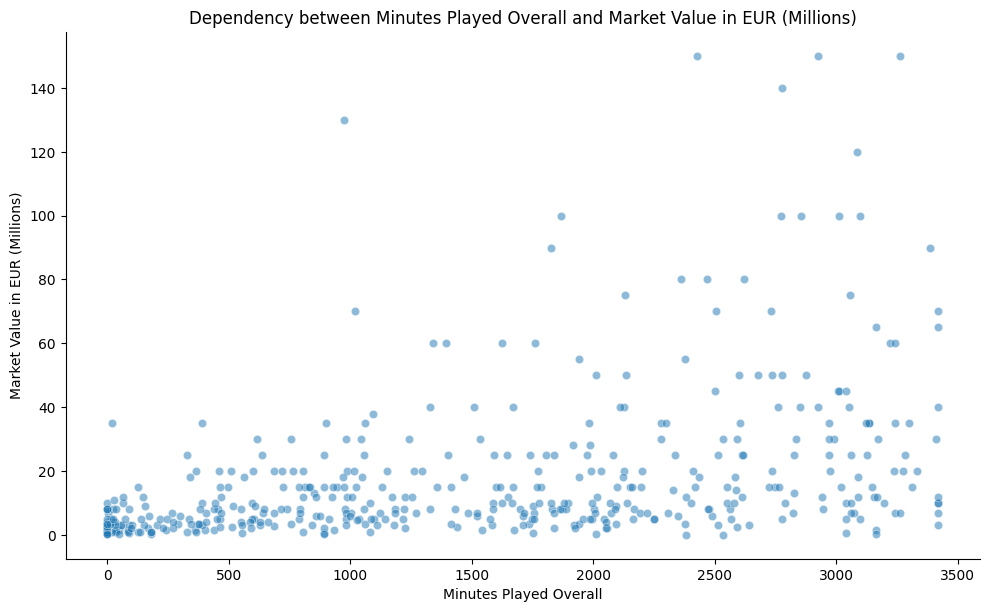

In [103]:

df = pd.read_csv("main.csv")

df['market_value_in_eur'] = df['market_value_in_eur'] / 1000000


sns.relplot(x='minutes_played_overall', y='market_value_in_eur', data=df, alpha=0.5, height=6, aspect=10/6).set_axis_labels('Minutes Played Overall', 'Market Value in EUR (Millions)').set(title='Dependency between Minutes Played Overall and Market Value in EUR (Millions)')



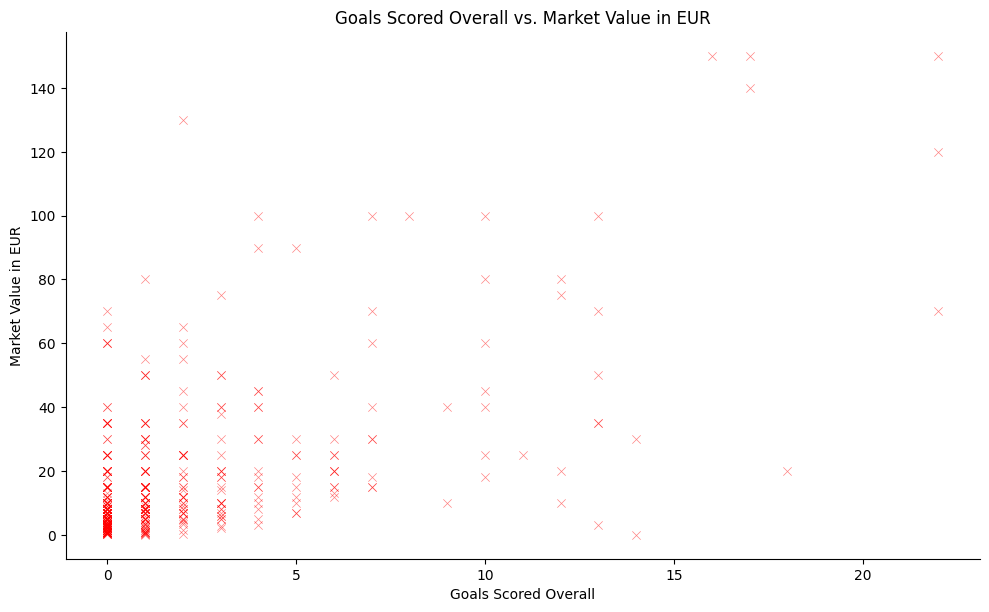

In [104]:
sns.relplot(x='goals_overall', y='market_value_in_eur', data=df, alpha=0.5, marker='x', color='red', height=6, aspect=10/6).set_axis_labels('Goals Scored Overall', 'Market Value in EUR').set(title='Goals Scored Overall vs. Market Value in EUR')


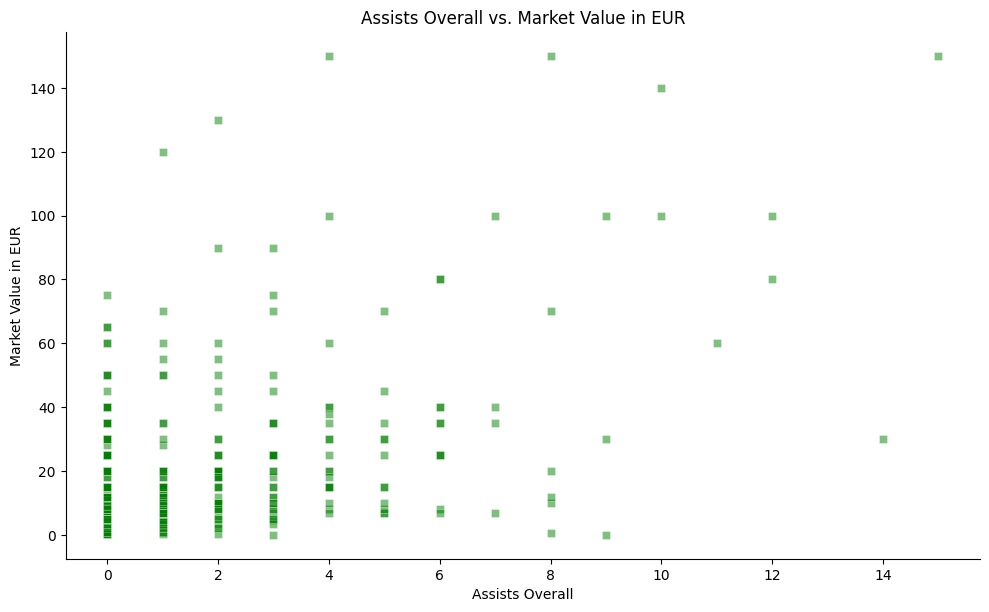

In [105]:


sns.relplot(x='assists_overall', y='market_value_in_eur', data=df, alpha=0.5, marker='s', color='green', height=6, aspect=10/6).set_axis_labels('Assists Overall', 'Market Value in EUR').set(title='Assists Overall vs. Market Value in EUR')



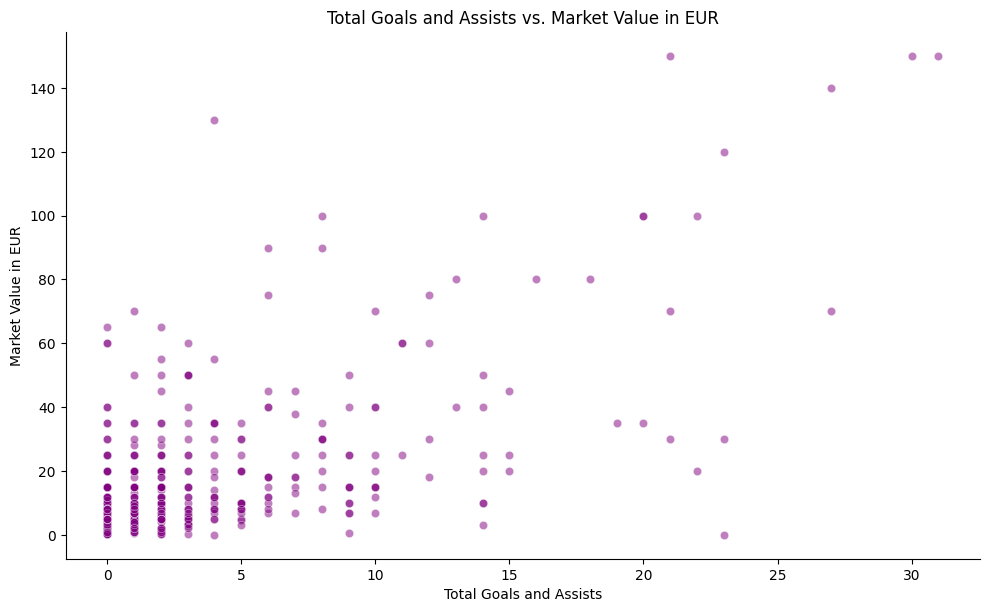

In [106]:


df['total_goals_assists'] = df['assists_overall'] + df['goals_overall']


sns.relplot(x='total_goals_assists', y='market_value_in_eur', data=df, alpha=0.5, marker='o', color='purple', height=6, aspect=10/6).set_axis_labels('Total Goals and Assists', 'Market Value in EUR').set(title='Total Goals and Assists vs. Market Value in EUR')



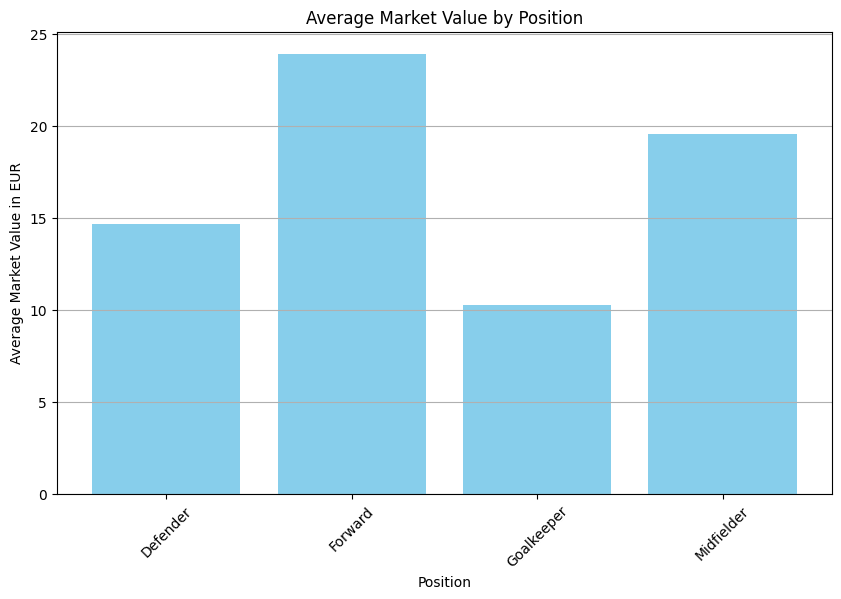

In [107]:
position_avg_price = df.groupby('position')['market_value_in_eur'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(position_avg_price['position'], position_avg_price['market_value_in_eur'], color='skyblue')
plt.title('Average Market Value by Position')
plt.xlabel('Position')
plt.ylabel('Average Market Value in EUR')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

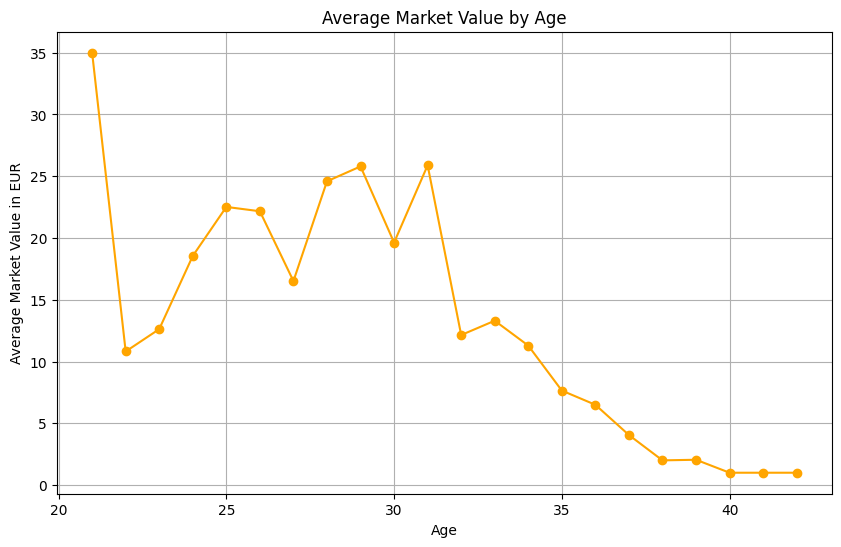

In [108]:
age_avg_price = df.groupby('age')['market_value_in_eur'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(age_avg_price['age'], age_avg_price['market_value_in_eur'], marker='o', color='orange')
plt.title('Average Market Value by Age')
plt.xlabel('Age')
plt.ylabel('Average Market Value in EUR')
plt.grid(True)
plt.show()


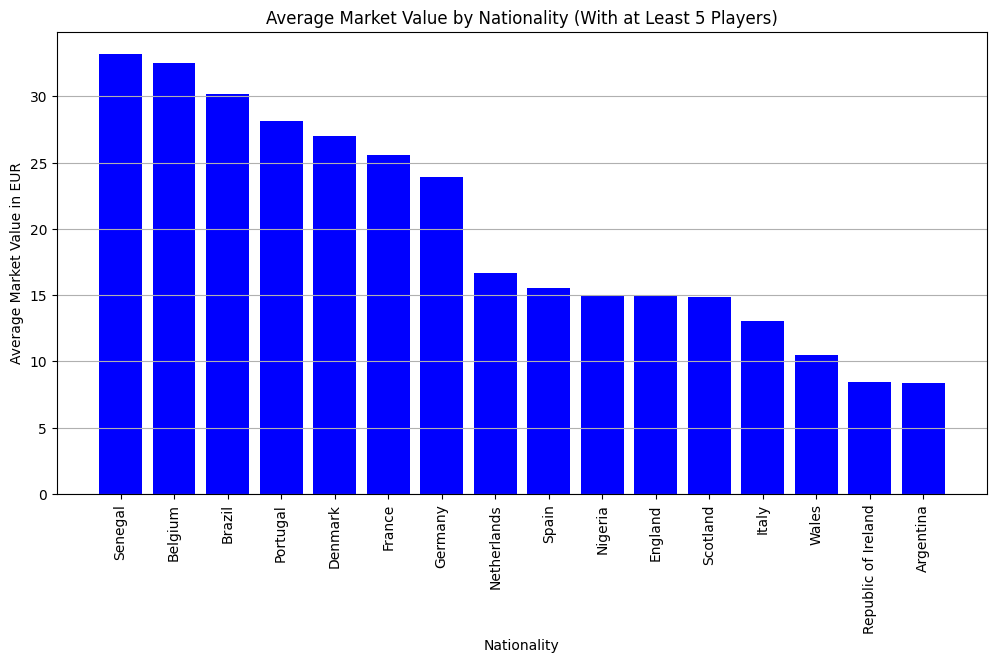

In [109]:
nationality_counts = df['nationality'].value_counts()


nationalities_with_5_players = nationality_counts[nationality_counts >= 5].index.tolist()


df_filtered = df[df['nationality'].isin(nationalities_with_5_players)]


nationality_avg_price = df_filtered.groupby('nationality')['market_value_in_eur'].mean().reset_index()


nationality_avg_price = nationality_avg_price.sort_values(by='market_value_in_eur', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(nationality_avg_price['nationality'], nationality_avg_price['market_value_in_eur'], color='blue')
plt.title('Average Market Value by Nationality (With at Least 5 Players)')
plt.xlabel('Nationality')
plt.ylabel('Average Market Value in EUR')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

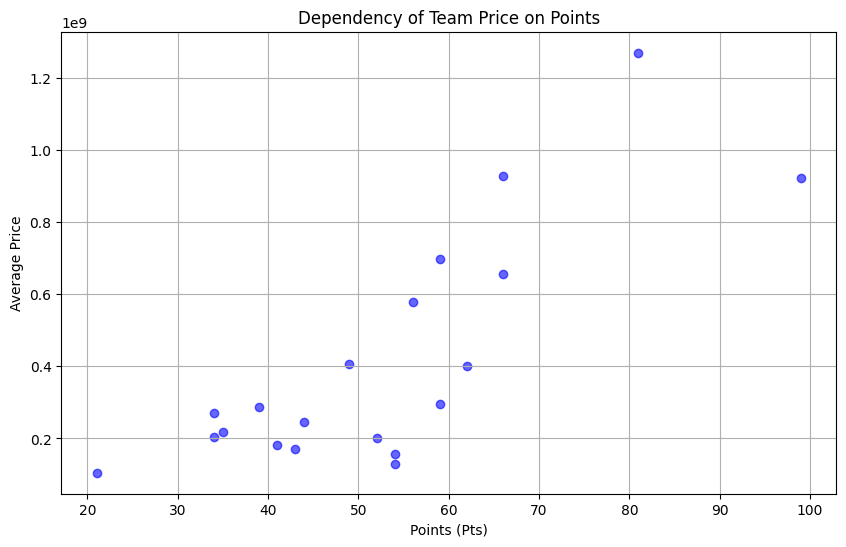

In [110]:


    
    plt.figure(figsize=(10, 6))
    plt.scatter(table_of_team_results['Pts'], table_of_team_results['Team Price'], color='blue', alpha=0.6)
    plt.title('Dependency of Team Price on Points')
    plt.xlabel('Points (Pts)')
    plt.ylabel('Average Price')
    plt.grid(True)
    plt.show()



## Functions for model scores

In [111]:

def get_model_scores(test, predicted):
    return mean_absolute_error(test, predicted), mean_squared_error(test, predicted), root_mean_squared_error(test, predicted), r2_score(test, predicted)

def print_model_scores(test, predicted, model):
    mae, mse, rms, r2 = get_model_scores(test, predicted)
    print(f'{model} Scores:\nMean Absolute Error: {mae}\nMean Squared Error: {mse}\nRoot Mean Squared Error: {rms}\nR2 score: {r2}')


# Missing data

## Looking for missing data

In [112]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   full_name               447 non-null    object 
 1   age                     447 non-null    int64  
 2   birthday_GMT            447 non-null    object 
 3   league                  447 non-null    object 
 4   season                  447 non-null    object 
 5   position                447 non-null    object 
 6   Current Club            447 non-null    object 
 7   minutes_played_overall  447 non-null    int64  
 8   nationality             447 non-null    object 
 9   goals_overall           447 non-null    int64  
 10  assists_overall         447 non-null    int64  
 11  market_value_in_eur     447 non-null    float64
 12  Teams                   354 non-null    object 
 13  Pts                     354 non-null    float64
 14  Team Price              354 non-null    fl

## We see that we got only 354 players with team price

In [113]:
merged_df = merged_df.drop(columns=['birthday_GMT', 'league', 'season', 'Teams'])
merged_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   full_name               447 non-null    object 
 1   age                     447 non-null    int64  
 2   position                447 non-null    object 
 3   Current Club            447 non-null    object 
 4   minutes_played_overall  447 non-null    int64  
 5   nationality             447 non-null    object 
 6   goals_overall           447 non-null    int64  
 7   assists_overall         447 non-null    int64  
 8   market_value_in_eur     447 non-null    float64
 9   Pts                     354 non-null    float64
 10  Team Price              354 non-null    float64
dtypes: float64(3), int64(4), object(4)
memory usage: 38.5+ KB


## Filling randomly with average value in column +-30%

In [114]:
def random_within_range(avg):
    lower_bound = avg * 0.7
    upper_bound = avg * 1.3
    return int(random.uniform(lower_bound, upper_bound))


avg_pts = merged_df['Pts'].mean()
avg_team_price = merged_df['Team Price'].mean()

# Fill missing values with a random value within ±30% of the average
merged_df['Pts'] = merged_df['Pts'].apply(lambda x: random_within_range(avg_pts) if pd.isna(x) else x)
merged_df['Team Price'] = merged_df['Team Price'].apply(lambda x: random_within_range(avg_team_price) if pd.isna(x) else x)

print(merged_df)
merged_df.info()



             full_name  age    position            Current Club  \
0      Aaron Cresswell   32    Defender         West Ham United   
1         Aaron Lennon   35  Midfielder                 Burnley   
2           Aaron Mooy   32  Midfielder       Huddersfield Town   
3         Aaron Ramsey   31  Midfielder                 Arsenal   
4    Aaron Wan-Bissaka   24  Midfielder          Crystal Palace   
..                 ...  ...         ...                     ...   
442         Yan Valery   23    Defender             Southampton   
443         Yerry Mina   28    Defender                 Everton   
444     Yoshinori Muto   30     Forward        Newcastle United   
445    Youri Tielemans   25  Midfielder          Leicester City   
446      Yves Bissouma   26  Midfielder  Brighton & Hove Albion   

     minutes_played_overall nationality  goals_overall  assists_overall  \
0                      1589     England              0                1   
1                      1217     England      

# Data processing

## Encode String to Int (position and nationality columns)

In [115]:
label_encoder = LabelEncoder()



merged_df['position'] = label_encoder.fit_transform(merged_df['position'])
merged_df['nationality'] = label_encoder.fit_transform(merged_df['nationality'])
print(merged_df)


             full_name  age  position            Current Club  \
0      Aaron Cresswell   32         0         West Ham United   
1         Aaron Lennon   35         3                 Burnley   
2           Aaron Mooy   32         3       Huddersfield Town   
3         Aaron Ramsey   31         3                 Arsenal   
4    Aaron Wan-Bissaka   24         3          Crystal Palace   
..                 ...  ...       ...                     ...   
442         Yan Valery   23         0             Southampton   
443         Yerry Mina   28         0                 Everton   
444     Yoshinori Muto   30         1        Newcastle United   
445    Youri Tielemans   25         3          Leicester City   
446      Yves Bissouma   26         3  Brighton & Hove Albion   

     minutes_played_overall  nationality  goals_overall  assists_overall  \
0                      1589           17              0                1   
1                      1217           17              1            

## Training and test data

In [116]:
X = merged_df[[ 'age', 'position', 'minutes_played_overall', 'nationality', 'goals_overall', 'assists_overall', 'Pts', 'Team Price']]
Y = merged_df['market_value_in_eur']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)



# LinearRegression

In [117]:
model_lin = LinearRegression()
model_lin.fit(X_train, Y_train)

lin_predicted = model_lin.predict(X_test)
print_model_scores(Y_test, lin_predicted, 'Linear Regression')

Linear Regression Scores:
Mean Absolute Error: 9697721.440011078
Mean Squared Error: 179566806079651.72
Root Mean Squared Error: 13400253.955789484
R2 score: 0.5465760064680723


# SVM with SS

In [118]:
clf = SVR(kernel='rbf')
sc = StandardScaler()

sc.fit(X_train)

X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

clf.fit(X_train_sc, Y_train)
sc_predicted = clf.predict(X_test_sc)
print_model_scores(Y_test, sc_predicted, 'StandardScaler')

StandardScaler Scores:
Mean Absolute Error: 11235259.900668273
Mean Squared Error: 425848157454091.0
Root Mean Squared Error: 20636088.715017945
R2 score: -0.07530883021551826


# Random Forest

In [119]:
random_forest_model = RandomForestRegressor()
random_forest_model.fit(X_train, Y_train)

random_forest_predicted = random_forest_model.predict(X_test)
print_model_scores(Y_test, random_forest_predicted, 'Random Forest')

Random Forest Scores:
Mean Absolute Error: 7165243.080357143
Mean Squared Error: 148441231632564.6
Root Mean Squared Error: 12183646.073017905
R2 score: 0.6251711687638994


# GLM

In [120]:
glm_model = LinearRegression()
features = PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)
glm_model.fit(features.fit_transform(X_train), Y_train)

glm_predicted = glm_model.predict(features.fit_transform(X_test))
print_model_scores(Y_test, glm_predicted, 'GLM')

GLM Scores:
Mean Absolute Error: 6911690.471003569
Mean Squared Error: 112824069596917.75
Root Mean Squared Error: 10621867.519269751
R2 score: 0.7151080351651047


# Comparing results

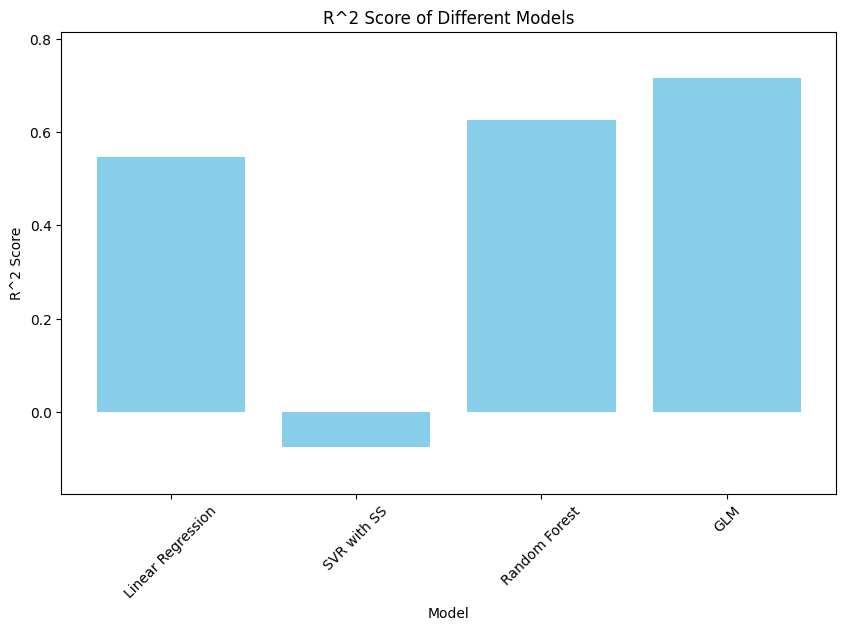

In [121]:
linreg_results = get_model_scores(Y_test, lin_predicted)
svm_results = get_model_scores(Y_test, sc_predicted)
random_forest_results = get_model_scores(Y_test, random_forest_predicted)
glm_results = get_model_scores(Y_test, glm_predicted)


model_names = ['Linear Regression', 'SVR with SS', 'Random Forest', 'GLM']
r2_scores = [linreg_results[3], svm_results[3], random_forest_results[3], glm_results[3]]


plt.figure(figsize=(10, 6))
plt.bar(model_names, r2_scores, color='skyblue')
plt.xlabel('Model')
plt.ylabel('R^2 Score')
plt.title('R^2 Score of Different Models')
plt.ylim(min(r2_scores) - 0.1, max(r2_scores) + 0.1) 
plt.xticks(rotation=45)
plt.show()
